# Seattle Housing Prices - Predictive Modeling

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from itertools import combinations

%run -i "functions/report.py"
%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"
%run -i "functions/add_interactions.py"
%run -i "functions/get_polynomials.py"
%run -i "functions/stepwise.py"
%run -i "functions/rmse_report.py"

### Model Adventure Map:

1. Vanilla model - no scaling or outliers
2. Outliers model - remove pricing outliers
3. Scaled model - min/max scale explanatory variables
4. Interactions model - find and add relevant interactions
5. Polynomial model - add polynomial variables
6. P-Filter Model - use stepwise function


#### Import Model Data

In [2]:
model_data = pd.read_csv('model_data.csv')
model_data.head()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
0,221900.0,3,1180,1.0,0.0,0.0,3,7,0,1955,...,0,1,0,0,0,0,0,0,0,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1,1951,...,0,1,0,0,0,0,1,0,0,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,0,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1,1965,...,0,1,0,0,0,0,1,0,0,0
4,510000.0,3,1680,1.0,0.0,0.0,3,8,0,1987,...,1,0,0,0,0,1,0,0,0,0


### Now Train-Test-Split

... in preparation for our baseline model

In [3]:
# Prepping variables for the model
outcome = 'price'
feat_cols = list(model_data.columns)
feat_cols.remove(outcome)

In [4]:
X = model_data[feat_cols]
y = model_data['price']

In [5]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Check lengths
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,1.0,3,1200,1.0,0.0,0.0,4,7,0,1969,...,0,0,0,0,0,0,0,0,0,0
19664,1.0,3,1920,1.0,0.0,0.0,3,8,0,2014,...,0,0,0,0,0,0,1,0,0,0
13949,1.0,3,1590,1.5,0.0,0.0,4,6,0,1926,...,0,0,0,0,0,1,0,0,0,0
15272,1.0,4,2530,3.0,0.0,2.0,3,9,1,2013,...,0,1,0,0,0,0,0,1,0,0
14411,1.0,3,2010,2.0,0.0,0.0,3,8,1,2014,...,0,0,0,0,0,0,1,0,0,0


### Model 1: Vanilla

#### Side Note: Model Function

In [6]:
def training_model(y_train, X_train):
    training_model.model = sm.OLS(y_train, X_train).fit()
    return training_model.model.summary()

In [7]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1135.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:11   Log-Likelihood:            -2.0418e+05
No. Observations:               15117   AIC:                         4.085e+05
Df Residuals:                   15074   BIC:                         4.088e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.152e+07   4.33e+06    -16.520      0.000      -8e+07    -6.3e+07
bedrooms            -2.55e+04   1982.617    -12.861      0.000   -2.94e+04   -2.16e+04
sqft_living          155.1339      3.539     43.833      0.000     148.197     162.071
floors               3.38e+04   3900.434      8.667      0.000    2.62e+04    4.14e+04
waterfront          6.416e+05   1.89e+04     33.932      0.000    6.05e+05    6.79e+05
view                 4.55e+04   2240.100     20.311      0.000    4.11e+04    4.99e+04
condition            2.56e+04   2517.067     10.170      0.000    2.07e+04    3.05e+04
grade               8.802e+04   2324.057     37.872      0.000    8.35e+04    9.26e+04
basement           -6431.1203   3675.173     -1.750      0.080   -1.36e+04     772.665
yr_built           -1749.0986     79.926    -21.884      0.000   -1905.764   -1592.434
renovated           3.593e+04   8413.864      4.270      0.000    1.94e+04    5.24e+04
lat                 5.838e+05   2.27e+04     25.735      0.000    5.39e+05    6.28e+05
long               -3.816e+05    3.5e+04    -10.908      0.000    -4.5e+05   -3.13e+05
sqft_living15         29.7710      3.772      7.893      0.000      22.378      37.164
month              -3635.3501    468.398     -7.761      0.000   -4553.467   -2717.233
city_Bellevue       2.114e+05   1.18e+04     17.976      0.000    1.88e+05    2.34e+05
city_Black Diamond  1.354e+05   2.37e+04      5.705      0.000    8.89e+04    1.82e+05
city_Bothell       -1.393e+05   1.95e+04     -7.143      0.000   -1.77e+05   -1.01e+05
city_Carnation      4.925e+04   2.64e+04      1.866      0.062   -2489.345    1.01e+05
city_Duvall         -4.83e+04   2.24e+04     -2.160      0.031   -9.21e+04   -4478.730
city_Enumclaw       1.716e+05    1.8e+04      9.533      0.000    1.36e+05    2.07e+05
city_Fall City      1.333e+05   2.75e+04      4.841      0.000    7.93e+04    1.87e+05
city_Federal Way   -7.547e+04   1.14e+04     -6.625      0.000   -9.78e+04   -5.31e+04
city_Issaquah       9.555e+04   1.39e+04      6.850      0.000    6.82e+04    1.23e+05
city_Kenmore       -1.617e+05   1.76e+04     -9.161      0.000   -1.96e+05   -1.27e+05
city_Kent          -5869.1212   9784.253     -0.600      0.549    -2.5e+04    1.33e+04
city_Kirkland       3.719e+04   1.35e+04      2.764      0.006    1.08e+04    6.36e+04
city_Maple Valley   8.188e+04   1.33e+04      6.157      0.000    5.58e+04    1.08e+05
city_Medina         8.837e+05    3.2e+04     27.599      0.000    8.21e+05    9.47e+05
city_Mercer Island  3.108e+05    1.6e+04     19.379      0.000    2.79e+05    3.42e+05
city_North Bend     1.825e+05   2.36e+04      7.748      0.000    1.36e+05    2.29e+05
city_Redmond        4.326e+04   1.43e+04      3.034      0.002    1.53e+04    7.12e+04
city_Renton         -1.35e+04   9969.0

In [8]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 177703.18334308316 
 Test RMSE: 188904.6781261696
Percent change:  6.303
Percent change (Base Model vs. Updated Model):  0.0


R-squared isn't bad at 0.759 (adjusted). Based on the initial model, I'm guessing most of the work will be around reducing error as guaged by the RMSE. 

Additionally, we noted during our EDA that there are several collinear variable pairs to be addressed. 

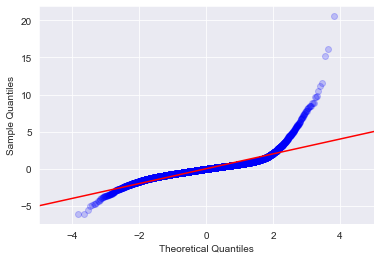

In [9]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

Our QQ plot for the vanilla model shows a non-normal graph with skew especially on the high end where there is likely a long tail of prices.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. Since our focus is on mid-range houses, it is reasonable to price-trim.

P.S. I bet the base model would've been better if it were vanilla bean...

### Model 2: Removing Outliers

Removing outliers based on 2 standard deviations (95%). This is because our business focus is not on the most expensive or the cheapest homes. So in order to improve our model's prediction for relevant prices, we'll narrow our scope.

If we still see a heavy tail, we will further narrow our price range.

#### Filtering price data at 2 standard deviations

In [10]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
pmodel_data = model_data[np.abs(stats.zscore(model_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(model_data.index.difference(pmodel_data.index)))
len(pmodel_data)

841


20756

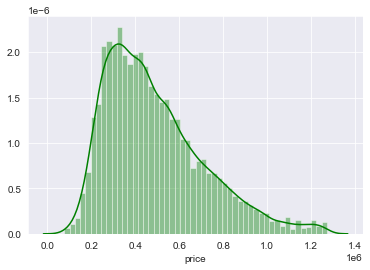

In [11]:
sns.distplot(pmodel_data.price, color='green');

We could try a log-transformation to deal with the skew that still exists. Or we could further narrow the price range. Based on experimentation between the two, we found best results in terms of RMSE reduction when narrowing the price. The trade-off here is a lower R-sqaured value.

#### Further price narrowing to reduce skew and for business case...

In [12]:
pmodel_data = pmodel_data[pmodel_data['price'] <= 790000]

In [13]:
# Reset X and y with new narrowed data
X = pmodel_data[feat_cols]
y = pmodel_data['price']

In [14]:
# Reset TTS since model data was changed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [15]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [16]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     758.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:20   Log-Likelihood:            -1.6555e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12915   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.288e+07    2.3e+06    -18.647      0.000   -4.74e+07   -3.84e+07
bedrooms           -9339.6496   1145.935     -8.150      0.000   -1.16e+04   -7093.448
sqft_living           68.1346      2.228     30.588      0.000      63.768      72.501
floors              2.919e+04   2085.258     13.999      0.000    2.51e+04    3.33e+04
waterfront          8.725e+04   1.83e+04      4.771      0.000    5.14e+04    1.23e+05
view                 2.17e+04   1470.276     14.758      0.000    1.88e+04    2.46e+04
condition           2.085e+04   1300.961     16.027      0.000    1.83e+04    2.34e+04
grade               4.955e+04   1299.898     38.119      0.000     4.7e+04    5.21e+04
basement            7616.0048   1942.840      3.920      0.000    3807.752    1.14e+04
yr_built           -1094.5707     43.545    -25.136      0.000   -1179.926   -1009.215
renovated           1.194e+04   4877.249      2.448      0.014    2380.288    2.15e+04
lat                 4.473e+05   1.14e+04     39.217      0.000    4.25e+05     4.7e+05
long               -1.924e+05   1.86e+04    -10.360      0.000   -2.29e+05   -1.56e+05
sqft_living15         40.6732      2.237     18.184      0.000      36.289      45.058
month              -1872.4038    240.590     -7.783      0.000   -2343.997   -1400.811
city_Bellevue       1.302e+05   6249.390     20.831      0.000    1.18e+05    1.42e+05
city_Black Diamond  1.406e+05   1.18e+04     11.887      0.000    1.17e+05    1.64e+05
city_Bothell       -5.802e+04   9803.067     -5.919      0.000   -7.72e+04   -3.88e+04
city_Carnation       4.15e+04   1.28e+04      3.250      0.001    1.65e+04    6.65e+04
city_Duvall        -3.268e+04    1.1e+04     -2.973      0.003   -5.42e+04   -1.11e+04
city_Enumclaw       1.099e+05   8661.153     12.694      0.000     9.3e+04    1.27e+05
city_Fall City      9.825e+04   1.49e+04      6.605      0.000    6.91e+04    1.27e+05
city_Federal Way   -4.663e+04   5483.589     -8.503      0.000   -5.74e+04   -3.59e+04
city_Issaquah       1.269e+05   7055.397     17.990      0.000    1.13e+05    1.41e+05
city_Kenmore       -7.714e+04   8631.606     -8.937      0.000   -9.41e+04   -6.02e+04
city_Kent           -1.36e+04   4658.074     -2.920      0.004   -2.27e+04   -4470.251
city_Kirkland       3.351e+04   6841.546      4.898      0.000    2.01e+04    4.69e+04
city_Maple Valley   5.488e+04   6516.619      8.422      0.000    4.21e+04    6.77e+04
city_Medina         3.963e+05   8.59e+04      4.614      0.000    2.28e+05    5.65e+05
city_Mercer Island  2.209e+05   1.31e+04     16.851      0.000    1.95e+05    2.47e+05
city_North Bend     1.274e+05   1.18e+04     10.816      0.000    1.04e+05    1.51e+05
city_Redmond        9.933e+04   7174.750     13.845      0.000    8.53e+04    1.13e+05
city_Renton         4630.5702   4812.8

In [17]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 85556.9037960636 
 Test RMSE: 87245.36622062251
Percent change:  1.973
Percent change (Base Model vs. Updated Model):  -51.854


A 51.85% improvement in RMSE as well as better predictability in the test set! Narrowing our price range reduced the error and made for a more normal model set (as seen below with the QQ plot).

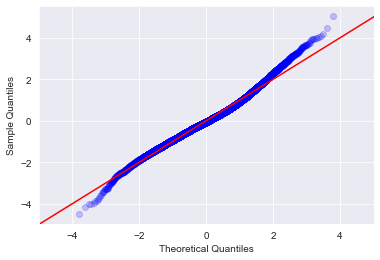

In [18]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 3: Scaling

Scaling after train, test, split to prevent data leakage

In [19]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)


# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

In [20]:
X_train_norm

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
6027,0.0,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19378,0.0,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9289,0.0,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6209,0.0,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4256,0.0,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.0,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18532,0.0,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7244,0.0,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10798,0.0,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Fixing the constant after scaling
X_train_norm.drop('const', axis=1, inplace=True)
X_test_norm.drop('const', axis=1, inplace=True)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

In [22]:
training_model(y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     758.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:26   Log-Likelihood:            -1.6555e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12915   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.659e+04   9323.540     -7.142      0.000   -8.49e+04   -4.83e+04
bedrooms           -8.406e+04   1.03e+04     -8.150      0.000   -1.04e+05   -6.38e+04
sqft_living         3.682e+05    1.2e+04     30.588      0.000    3.45e+05    3.92e+05
floors              7.298e+04   5213.144     13.999      0.000    6.28e+04    8.32e+04
waterfront          8.725e+04   1.83e+04      4.771      0.000    5.14e+04    1.23e+05
view                 8.68e+04   5881.105     14.758      0.000    7.53e+04    9.83e+04
condition            8.34e+04   5203.844     16.027      0.000    7.32e+04    9.36e+04
grade               3.964e+05   1.04e+04     38.119      0.000    3.76e+05    4.17e+05
basement            7616.0048   1942.840      3.920      0.000    3807.752    1.14e+04
yr_built           -1.259e+05   5007.727    -25.136      0.000   -1.36e+05   -1.16e+05
renovated           1.194e+04   4877.249      2.448      0.014    2380.288    2.15e+04
lat                 2.766e+05   7051.894     39.217      0.000    2.63e+05     2.9e+05
long               -2.316e+05   2.24e+04    -10.360      0.000   -2.75e+05   -1.88e+05
sqft_living15       1.737e+05   9553.301     18.184      0.000    1.55e+05    1.92e+05
month               -2.06e+04   2646.494     -7.783      0.000   -2.58e+04   -1.54e+04
city_Bellevue       1.302e+05   6249.390     20.831      0.000    1.18e+05    1.42e+05
city_Black Diamond  1.406e+05   1.18e+04     11.887      0.000    1.17e+05    1.64e+05
city_Bothell       -5.802e+04   9803.067     -5.919      0.000   -7.72e+04   -3.88e+04
city_Carnation       4.15e+04   1.28e+04      3.250      0.001    1.65e+04    6.65e+04
city_Duvall        -3.268e+04    1.1e+04     -2.973      0.003   -5.42e+04   -1.11e+04
city_Enumclaw       1.099e+05   8661.153     12.694      0.000     9.3e+04    1.27e+05
city_Fall City      9.825e+04   1.49e+04      6.605      0.000    6.91e+04    1.27e+05
city_Federal Way   -4.663e+04   5483.589     -8.503      0.000   -5.74e+04   -3.59e+04
city_Issaquah       1.269e+05   7055.397     17.990      0.000    1.13e+05    1.41e+05
city_Kenmore       -7.714e+04   8631.606     -8.937      0.000   -9.41e+04   -6.02e+04
city_Kent           -1.36e+04   4658.074     -2.920      0.004   -2.27e+04   -4470.251
city_Kirkland       3.351e+04   6841.546      4.898      0.000    2.01e+04    4.69e+04
city_Maple Valley   5.488e+04   6516.619      8.422      0.000    4.21e+04    6.77e+04
city_Medina         3.963e+05   8.59e+04      4.614      0.000    2.28e+05    5.65e+05
city_Mercer Island  2.209e+05   1.31e+04     16.851      0.000    1.95e+05    2.47e+05
city_North Bend     1.274e+05   1.18e+04     10.816      0.000    1.04e+05    1.51e+05
city_Redmond        9.933e+04   7174.750     13.845      0.000    8.53e+04    1.13e+05
city_Renton         4630.5702   4812.8

In [23]:
rmse_report(X_train_norm, X_test_norm, y_train, training_model.model)

Train RMSE: 85556.9037960637 
 Test RMSE: 87245.36622062171
Percent change:  1.973
Percent change (Base Model vs. Updated Model):  -51.854


No change after scaling. Based on earlier trials, the later models are improved with scaling as we look at relationships between explanatory variables.

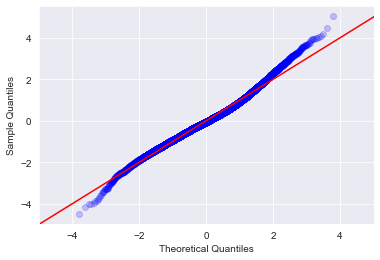

In [24]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 4: Interactions

In [25]:
linreg = LinearRegression()
model_int = linreg.fit(X_train_norm, y_train)

In [26]:
# A function testing for relevant interactions based on highest R-squared
interactions = find_interactions(20, model_int, X_train_norm)

Testing 903 combinations.

R^2 including interaction of long and city_Seattle: 0.719
R^2 including interaction of lat and city_Kirkland: 0.717
R^2 including interaction of yr_built and long: 0.716
R^2 including interaction of yr_built and city_Seattle: 0.716
R^2 including interaction of grade and city_Seattle: 0.715
R^2 including interaction of sqft_living15 and city_Federal Way: 0.714
R^2 including interaction of sqft_living and lat: 0.714
R^2 including interaction of sqft_living and basement: 0.714
R^2 including interaction of long and city_Kent: 0.714
R^2 including interaction of grade and city_Federal Way: 0.714
R^2 including interaction of basement and city_Seattle: 0.714
R^2 including interaction of yr_built and lat: 0.713
R^2 including interaction of sqft_living and yr_built: 0.713
R^2 including interaction of sqft_living and view: 0.713
R^2 including interaction of sqft_living and sqft_living15: 0.713
R^2 including interaction of sqft_living and floors: 0.713
R^2 including inte

In [27]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('yr_built', 'city_Seattle'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'basement'),
 ('long', 'city_Kent'),
 ('grade', 'city_Federal Way'),
 ('basement', 'city_Seattle'),
 ('yr_built', 'lat'),
 ('sqft_living', 'yr_built'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15'),
 ('sqft_living', 'floors'),
 ('sqft_living', 'city_Kent'),
 ('sqft_living', 'city_Federal Way'),
 ('grade', 'lat'),
 ('grade', 'city_Kent')]

Now that we have the list of desired interactions, we will create the new variables and plot their interaction in respect to y.


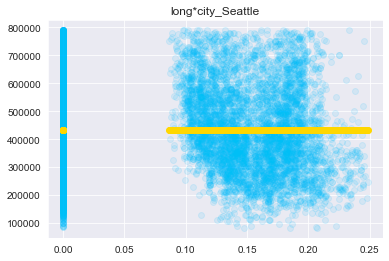

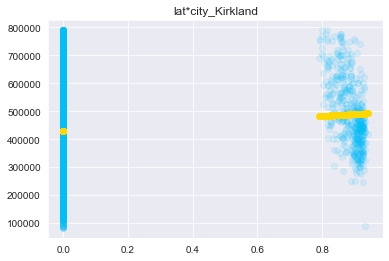

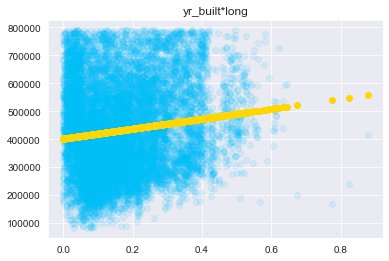

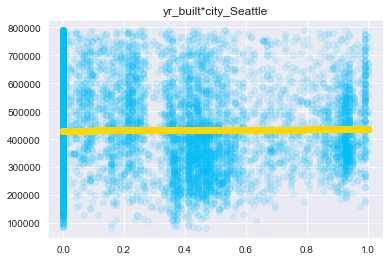

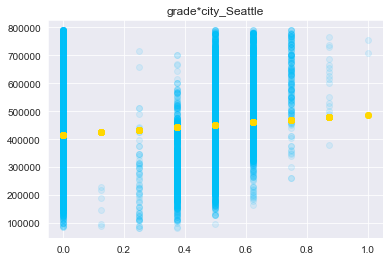

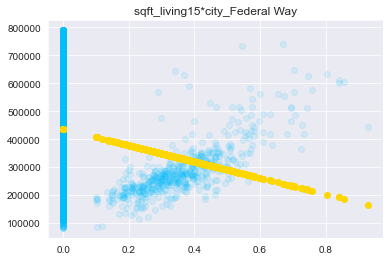

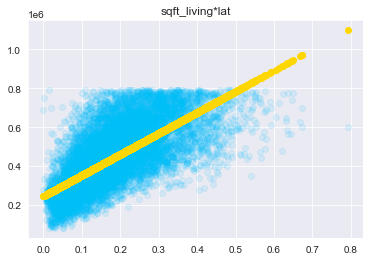

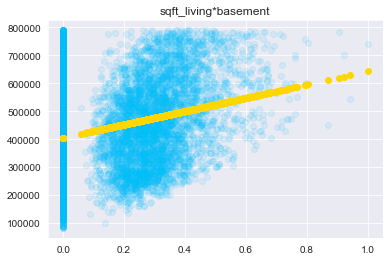

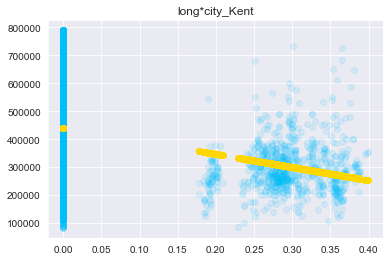

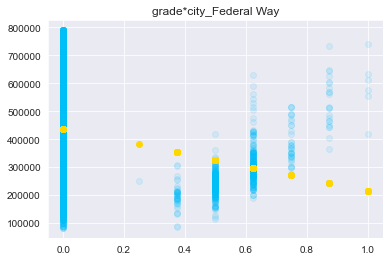

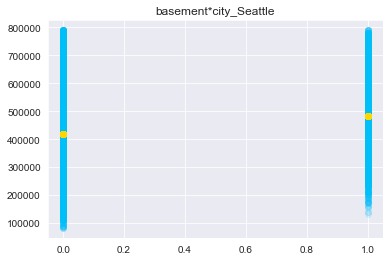

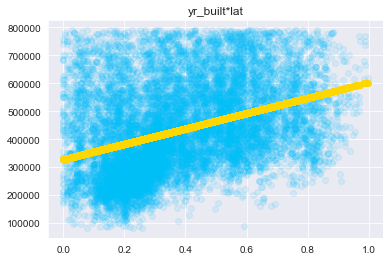

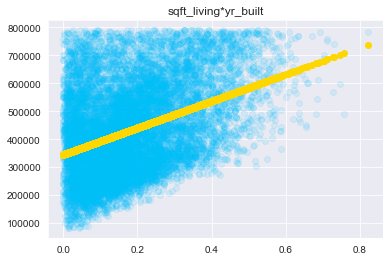

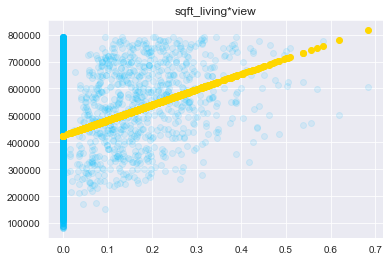

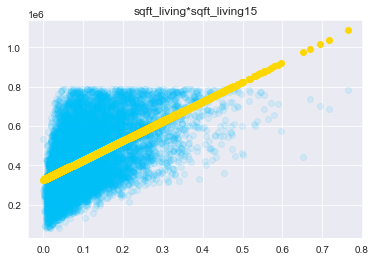

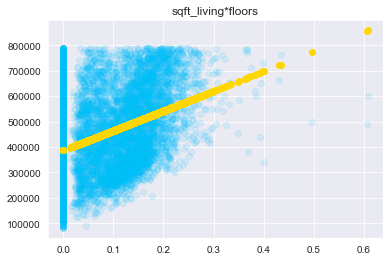

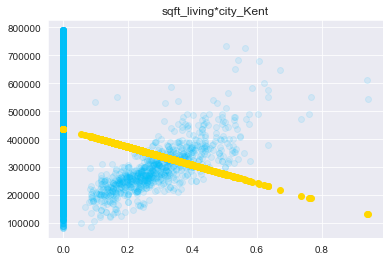

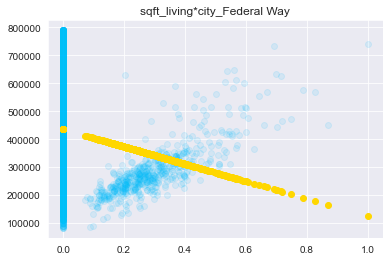

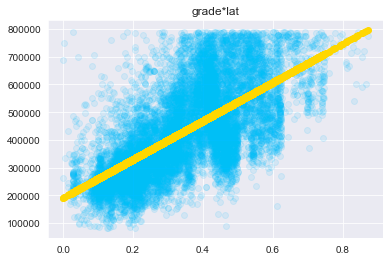

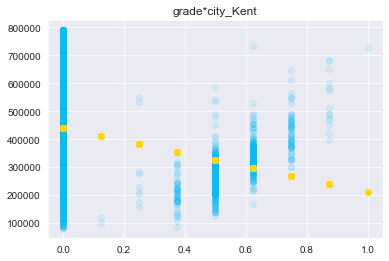

In [28]:
for inter in interactions:
    var = pd.DataFrame(X_train_norm[inter[0]] * X_train_norm[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    
    # plot this as a grid
#     plt.scatter(var, y_train, c='deepskyblue', alpha=.1)
#     plt.scatter(var, y_pred, c='gold')
#     plt.title('{}*{}'.format(inter[0], inter[1]))
#     plt.show()

In [29]:
# Remove the interactions saved as tuples that do not have a noticeable impact on price based on the graphs above
remove = [('long', 'city_Seattle'),
          ('yr_built', 'city_Seattle')]
for r in remove:
    interactions.remove(r)

In [30]:
len(interactions)

18

In [31]:
# Either simplify or remove this add_interactions function

In [32]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train_norm, X_test_norm)

Interaction Added: lat * city_Kirkland
Interaction Added: grade * city_Seattle
Interaction Added: sqft_living * basement
Interaction Added: yr_built * long
Interaction Added: long * city_Kent
Interaction Added: sqft_living * yr_built
Interaction Added: sqft_living * lat
Interaction Added: yr_built * lat
Interaction Added: sqft_living * view
Interaction Added: basement * city_Seattle
Interaction Added: grade * city_Kent
Interaction Added: grade * city_Federal Way
Interaction Added: sqft_living * sqft_living15
Interaction Added: sqft_living * city_Kent
Interaction Added: grade * lat
Interaction Added: sqft_living15 * city_Federal Way
Interaction Added: sqft_living * city_Federal Way
Interaction Added: sqft_living * floors


In [33]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     603.1
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:59   Log-Likelihood:            -1.6495e+05
No. Observations:               12958   AIC:                         3.300e+05
Df Residuals:                   12897   BIC:                         3.305e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             7.427e+04   1.72e+04      4.318      0.000    4.06e+04    1.08e+05
bedrooms                         -9.435e+04      1e+04     -9.418      0.000   -1.14e+05   -7.47e+04
sqft_living                       2.247e+05   3.93e+04      5.717      0.000    1.48e+05    3.02e+05
floors                            7.247e+04   1.18e+04      6.162      0.000    4.94e+04    9.55e+04
waterfront                        6.175e+04   1.78e+04      3.473      0.001    2.69e+04    9.66e+04
view                              1.568e+05   1.43e+04     10.951      0.000    1.29e+05    1.85e+05
condition                         8.294e+04   5026.910     16.499      0.000    7.31e+04    9.28e+04
grade                             2.869e+05    3.2e+04      8.972      0.000    2.24e+05     3.5e+05
basement                          2.651e+04   5161.488      5.136      0.000    1.64e+04    3.66e+04
yr_built                         -2.304e+05   1.93e+04    -11.948      0.000   -2.68e+05   -1.93e+05
renovated                         1.472e+04   4693.865      3.137      0.002    5523.803    2.39e+04
lat                               2.695e+05   1.94e+04     13.898      0.000    2.32e+05    3.08e+05
long                             -5.803e+05   3.04e+04    -19.060      0.000    -6.4e+05   -5.21e+05
sqft_living15                     1.965e+05   1.74e+04     11.305      0.000    1.62e+05    2.31e+05
month                            -2.075e+04   2529.912     -8.201      0.000   -2.57e+04   -1.58e+04
city_Bellevue                     1.536e+05   6198.020     24.784      0.000    1.41e+05    1.66e+05
city_Black Diamond                1.429e+05   1.14e+04     12.483      0.000     1.2e+05    1.65e+05
city_Bothell                     -4.245e+04   9789.312     -4.336      0.000   -6.16e+04   -2.33e+04
city_Carnation                    5.508e+04   1.27e+04      4.345      0.000    3.02e+04    7.99e+04
city_Duvall                      -2.607e+04   1.12e+04     -2.324      0.020   -4.81e+04   -4078.308
city_Enumclaw                     1.199e+05   8449.830     14.187      0.000    1.03e+05    1.36e+05
city_Fall City                    1.279e+05   1.44e+04      8.855      0.000    9.96e+04    1.56e+05
city_Federal Way                  2.885e+04   2.17e+04      1.332      0.183   -1.36e+04    7.13e+04
city_Issaquah                     1.388e+05   7134.855     19.449      0.000    1.25e+05    1.53e+05
city_Kenmore                     -6.265e+04   8612.799     -7.274      0.000   -7.95e+04   -4.58e+04
city_Kent                        -8.164e+04   2.49e+04     -3.283      0.001    -1.3e+05   -3.29e+04
city_Kirkland                     1.544e+06   9.15e+04     16.873      0.000    1.36e+06    1.72e+06
city_Maple Valley                 4.608e+04   6507.33

In [34]:
rmse_report(X_train2, X_test2, y_train, training_model.model)

Train RMSE: 81674.04763875317 
 Test RMSE: 83265.82893948955
Percent change:  1.949
Percent change (Base Model vs. Updated Model):  -54.039


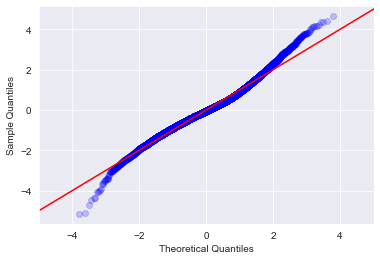

In [35]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [36]:
# Adding interactions decreased RMSE and improved R-squared

### Model: Polynomial Features

In [37]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 2)

In [38]:
poly_feat

[('bedrooms', 2),
 ('sqft_living', 2),
 ('floors', 2),
 ('view', 2),
 ('condition', 2),
 ('grade', 2),
 ('yr_built', 2),
 ('lat', 2),
 ('long', 2),
 ('sqft_living15', 2),
 ('month', 2),
 ('city_Bellevue', 2),
 ('lat * city_Kirkland', 2),
 ('grade * city_Seattle', 2),
 ('sqft_living * basement', 2),
 ('yr_built * long', 2),
 ('long * city_Kent', 2),
 ('sqft_living * yr_built', 2),
 ('sqft_living * lat', 2),
 ('yr_built * lat', 2),
 ('sqft_living * view', 2),
 ('grade * city_Kent', 2),
 ('grade * city_Federal Way', 2),
 ('sqft_living * sqft_living15', 2),
 ('sqft_living * city_Kent', 2),
 ('grade * lat', 2),
 ('sqft_living15 * city_Federal Way', 2),
 ('sqft_living * city_Federal Way', 2),
 ('sqft_living * floors', 2)]

In [39]:
#Perform the same function as PolynomialFeatures, but naming the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [40]:
X_train3 = sm.add_constant(X_train3)
X_test3 = sm.add_constant(X_test3)

In [41]:
training_model(y_train, X_train3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     469.7
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:36:10   Log-Likelihood:            -1.6429e+05
No. Observations:               12958   AIC:                         3.288e+05
Df Residuals:                   12869   BIC:                         3.294e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -4.569e+04   3.81e+04     -1.198      0.231    -1.2e+05    2.91e+04
bedrooms                           -6.112e+04   2.83e+04     -2.160      0.031   -1.17e+05   -5666.331
sqft_living                         1.779e+05   9.78e+04      1.820      0.069   -1.37e+04     3.7e+05
floors                             -1.019e+05   2.33e+04     -4.376      0.000   -1.48e+05   -5.63e+04
waterfront                          8.588e+04   1.86e+04      4.625      0.000    4.95e+04    1.22e+05
view                                5.585e+04    3.6e+04      1.549      0.121   -1.48e+04    1.26e+05
condition                           1.053e+05   2.95e+04      3.571      0.000    4.75e+04    1.63e+05
grade                              -5.124e+05   1.02e+05     -5.029      0.000   -7.12e+05   -3.13e+05
basement                            1.221e+04   9079.261      1.345      0.179   -5588.844       3e+04
yr_built                            1.594e+05   5.17e+04      3.085      0.002    5.81e+04    2.61e+05
renovated                           1.801e+04   4480.273      4.020      0.000    9230.327    2.68e+04
lat                                 1.278e+06   7.88e+04     16.222      0.000    1.12e+06    1.43e+06
long                               -7.562e+05   6.54e+04    -11.566      0.000   -8.84e+05   -6.28e+05
sqft_living15                        2.63e+05   4.11e+04      6.394      0.000    1.82e+05    3.44e+05
month                              -1.831e+04   9153.513     -2.000      0.046   -3.62e+04    -362.915
city_Bellevue                      -6626.7793   4351.157     -1.523      0.128   -1.52e+04    1902.134
city_Black Diamond                  1.041e+05    1.1e+04      9.445      0.000    8.25e+04    1.26e+05
city_Bothell                        -1.51e+05   1.02e+04    -14.730      0.000   -1.71e+05   -1.31e+05
city_Carnation                     -1.294e+05    1.4e+04     -9.258      0.000   -1.57e+05   -1.02e+05
city_Duvall                        -1.696e+05   1.18e+04    -14.397      0.000   -1.93e+05   -1.46e+05
city_Enumclaw                       2.485e+05   9410.840     26.410      0.000     2.3e+05    2.67e+05
city_Fall City                     -6.317e+04   1.54e+04     -4.114      0.000   -9.33e+04   -3.31e+04
city_Federal Way                    1.108e+04   6.66e+04      0.166      0.868   -1.19e+05    1.42e+05
city_Issaquah                      -2.561e+04   9197.686     -2.785      0.005   -4.36e+04   -7584.786
city_Kenmore                       -1.753e+05   9191.155    -19.078      0.000   -1.93e+05   -1.57e+05
city_Kent                           9.149e+04   8.67e+04      1.056      0.291   -7.84e+04    2.61e+05
city_Kirkland                       8.437e+05   2.13e+06      0.397      0.691   -3.32e+06    5.

In [42]:
rmse_report(X_train3, X_test3, y_train, training_model.model)

Train RMSE: 77637.19611065902 
 Test RMSE: 78900.62418077212
Percent change:  1.627
Percent change (Base Model vs. Updated Model):  -56.311


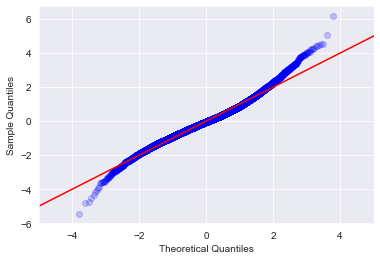

In [43]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### P-Value Filter

In [44]:
result = stepwise_selection(X_train3, y_train, verbose=True)
print('resulting features:')
print(result)

/Users/stephenenke/Documents/DSC-Project-2/Seattle-Housing-Regression-Analysis/functions/stepwise.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade * lat                    with p-value 0.0
Add  sqft_living * yr_built^2       with p-value 0.0
Add  sqft_living * sqft_living15    with p-value 0.0
Add  const                          with p-value 0.0
Add  yr_built * lat                 with p-value 1.0703e-222
Add  grade * lat^2                  with p-value 6.03452e-159
Add  sqft_living * sqft_living15^2  with p-value 2.32609e-111
Add  view                           with p-value 1.57213e-85
Add  city_Bellevue^2                with p-value 9.339e-77
Add  city_Bellevue                  with p-value 9.339e-77
Add  city_Enumclaw                  with p-value 3.57138e-68
Add  condition^2                    with p-value 7.61355e-50
Add  floors                         with p-value 5.17911e-62
Add  city_Mercer Island             with p-value 1.05383e-48
Add  city_Redmond                   with p-value 5.4369e-46
Add  city_Issaquah                  with p-value 1.66696e-46
Drop const                          with p-value 0.442456
A

In [45]:
len(result)

63

In [58]:
X_train4 = X_train3.loc[:,result]
X_test4 = X_test3.loc[:,result]
X_train4 = sm.add_constant(X_train4)
X_test4 = sm.add_constant(X_test4)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

crossval = KFold(n_splits = 10, shuffle = True)

In [59]:
training_model(y_train, X_train4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     664.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:45:36   Log-Likelihood:            -1.6431e+05
No. Observations:               12958   AIC:                         3.288e+05
Df Residuals:                   12895   BIC:                         3.292e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.625e+04   3.34e+04     -0.487      0.626   -8.16e+04    4.91e+04
grade * lat                  8.369e+05    1.4e+05      5.970      0.000    5.62e+05    1.11e+06
sqft_living * yr_built^2      2.41e+05    4.5e+04      5.350      0.000    1.53e+05    3.29e+05
yr_built * lat              -7.673e+05    5.5e+04    -13.952      0.000   -8.75e+05   -6.59e+05
grade * lat^2               -6.058e+05   9.75e+04     -6.212      0.000   -7.97e+05   -4.15e+05
view                         1.426e+05   1.37e+04     10.390      0.000    1.16e+05    1.69e+05
city_Bellevue^2              1.312e+04   2297.218      5.709      0.000    8612.583    1.76e+04
city_Bellevue                1.312e+04   2297.218      5.709      0.000    8612.583    1.76e+04
city_Enumclaw                2.419e+05   8716.216     27.754      0.000    2.25e+05    2.59e+05
floors                      -1.001e+05   2.29e+04     -4.382      0.000   -1.45e+05   -5.54e+04
city_Mercer Island           1.083e+05   1.18e+04      9.188      0.000    8.52e+04    1.31e+05
city_Issaquah                1.624e+04   4426.511      3.668      0.000    7558.823    2.49e+04
basement * city_Seattle      1.051e+04   3257.501      3.226      0.001    4122.897    1.69e+04
yr_built * lat^2             4.423e+05   3.67e+04     12.037      0.000     3.7e+05    5.14e+05
city_Kirkland                5.918e+05   4.47e+04     13.235      0.000    5.04e+05    6.79e+05
lat * city_Kirkland^2       -8.135e+05   5.66e+04    -14.381      0.000   -9.24e+05   -7.03e+05
yr_built * long^2           -2.168e+05   1.15e+05     -1.892      0.059   -4.41e+05    7829.306
long                        -7.721e+05   6.44e+04    -11.996      0.000   -8.98e+05   -6.46e+05
city_Black Diamond           1.225e+05      1e+04     12.236      0.000    1.03e+05    1.42e+05
city_Duvall                  -1.25e+05   7765.751    -16.097      0.000    -1.4e+05    -1.1e+05
sqft_living * lat            5.775e+05   9.48e+04      6.091      0.000    3.92e+05    7.63e+05
grade * city_Seattle         2.233e+05   1.77e+04     12.615      0.000    1.89e+05    2.58e+05
sqft_living * lat^2          -5.44e+05   1.11e+05     -4.912      0.000   -7.61e+05   -3.27e+05
bedrooms                    -7.209e+04   9675.070     -7.451      0.000   -9.11e+04   -5.31e+04
city_Kenmore                 -1.43e+05   6642.576    -21.528      0.000   -1.56e+05    -1.3e+05
sqft_living15                2.641e+05   1.96e+04     13.479      0.000    2.26e+05    3.03e+05
month                       -2.087e+04   2409.793     -8.662      0.000   -2.56e+04   -1.61e+04
city_Renton                 -9.793e+04   3577.678    -27.373      0.000   -1.05e+05   -9.09e+04
lat^2                       -6.691e+05   3.35e+04    -19.942      0.000   -7.35e+05   -6.03e+05
lat        

In [60]:
rmse_report(X_train4, X_test4, y_train, training_model.model)

Train RMSE: 77772.56378704724 
 Test RMSE: 78721.96709791309
Percent change:  1.221
Percent change (Base Model vs. Updated Model):  -56.235


In [61]:
linreg = LinearRegression()
model_final = linreg.fit(X_train4, y_train)

************
High Impact Variables:

Variable: grade * lat
Coefficient: 804107.0554313979

Variable: yr_built * lat
Coefficient: -799156.7071081145

Variable: city_Bellevue^2
Coefficient: 1.1066880182318767e+18

Variable: city_Bellevue
Coefficient: -1.1066880182318497e+18

Variable: lat * city_Kirkland^2
Coefficient: -808448.0

Variable: lat
Coefficient: 1149824.0

Variable: long * city_Kent^2
Coefficient: 1018880.0

Variable: sqft_living * floors^2
Coefficient: -1230682.0

Train R^2: 0.7614718257178578
CrossValidated R^2: 0.758080765270026
Test R^2: 0.7546748573809261



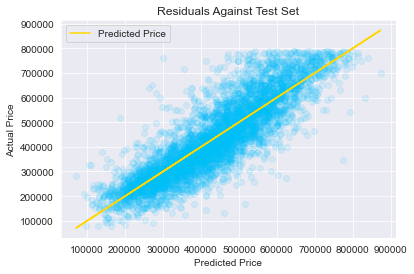

In [62]:
report(model_final, X_train4, X_test4)

And that is where our modeling will end. We've improved the R-squared score by only 0.01 but a high R-squared in the vanilla model can likely be attributed to collinearity in the data.

Our main focus was reducing the error in our pricing predictions which we have done so by nearly $100,000 or a 56.27% improvement. Additionally, we see similar accuracy between the train and testing data. With cross-validation, we find that the predicted prices are even closer to the training data. This points to better generalization of our model when it's released into the wild.

Looking at the plot of predicted price versus actual price, we find the predicted price fits quite well. Towards the upper end of our price range, we do find that the model falls off a bit. We have more confidence in our predictions for prices in the middle of our model's price range.